In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import sys
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process the diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from functions import (wls_fit_tensor, nlls_fit_tensor)
# from dipy.reconst.fwdti import (wls_fit_tensor, nlls_fit_tensor)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

SNR = 40

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
gtab = gradient_table(bvals, bvecs)
design_matrix = dti.design_matrix(gtab)

In [3]:
# ---------------------------------------------------------------
# Ground truth values of tissue's diffusion tensor and
# water volume fraction
# ---------------------------------------------------------------

# free water component
VF = np.linspace(0, 100, num=11)
Dwater = 3e-3

# tissue component
FA = np.array([0., 0.11, 0.22, 0.30, 0.71])
L1 = np.array([0.8e-3, 0.900e-3, 1.000e-3, 1.080e-3, 1.6e-03])
L2 = np.array([0.8e-3, 0.763e-3, 0.725e-3, 0.695e-3, 0.5e-03])
L3 = np.array([0.8e-3, 0.738e-3, 0.675e-3, 0.625e-3, 0.3e-03])

# simulations are repeated for 120 different diffusion tensor's
# directions (and each direction repeated 100 times)
nDTdirs = 120
theta = np.pi * np.random.rand(nDTdirs)
phi = 2 * np.pi * np.random.rand(nDTdirs)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
DTdirs = hsph_updated.vertices # directions for each shell

nrep = 100  # number of repetitions for each direction

In [4]:
# ----------------------------------------------------------------
# Generate simulations
# ----------------------------------------------------------------

DWI_simulates = np.empty((FA.size, VF.size, nrep * nDTdirs,
                          bvals.size))

for fa_i in range(FA.size):
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])
    for vf_i in range(VF.size):
        fractions = [100 - VF[vf_i], VF[vf_i]]
        for di in range(nDTdirs):
            d = DTdirs[di]
            for s_i in np.arange(di * nrep, (di+1) * nrep):
                signal, sticks = multi_tensor(gtab, mevals,
                                              S0=100,
                                              angles=[d, (1, 0, 0)],
                                              fractions=fractions,
                                              snr=SNR)
                DWI_simulates[fa_i, vf_i, s_i, :] = signal
    prog = (fa_i+1.0) / FA.size
    time.sleep(1)
    sys.stdout.write("\r%f%%" % prog)
    sys.stdout.flush()

1.000000%

In [5]:
# ---------------------------------------------------------------
# fit the free water elimination DTI model
# ---------------------------------------------------------------

# find S0 from data
S0 = np.mean(DWI_simulates[:, :, :, bvals==0], axis=3)
# Select the cases that bmax > bmin
mask = S0 > 0

t0 = time.time()
# WLLS procedures is used to estimate parameters initial guess
fw_params_initial = wls_fit_tensor(design_matrix, DWI_simulates,
                                   Diso=Dwater, S0=S0, mask=mask)
print(time.time() - t0)

722.72300005


In [6]:
fw_params = fw_params_initial.copy()

t0 = time.time()
# NLLS procedures is used to find final parameters guess
fw_params = nlls_fit_tensor(design_matrix, DWI_simulates, 
                            fw_params=fw_params, Diso=Dwater,
                            cholesky=True, f_transform=True,
                            mask=mask)
print(time.time() - t0)

4442.82399988


C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


C:\Users\Rafael\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


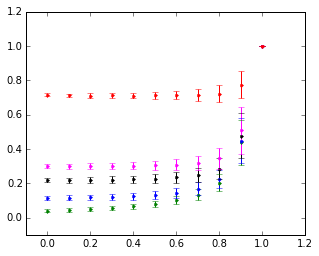

In [7]:
# ---------------------------------------------------------------
# Process diffusion tensor standard measures and plot
# ---------------------------------------------------------------

evals = fw_params[..., :3]
fa = dti.fractional_anisotropy(evals)
f = fw_params[..., 12]

median_fa = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

plt.figure(figsize=(5, 4))
plt.axis([-0.1, 1.2, -0.1, 1.2])
for fa_i in range(FA.size):
    for vf_i in range(VF.size):
        median_fa[vf_i] = np.median(fa[fa_i, vf_i, :])
        p25, p75 = np.percentile(fa[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_fa[vf_i] - p25 
        lower_p[vf_i] = p75 - median_fa[vf_i]
    plt.errorbar(VF/100, median_fa, fmt='.',
                 yerr=[lower_p, lower_p],
                 color=colors[fa_i],
                 ecolor=colors[fa_i],
                 linewidth=1.0)
plt.show()

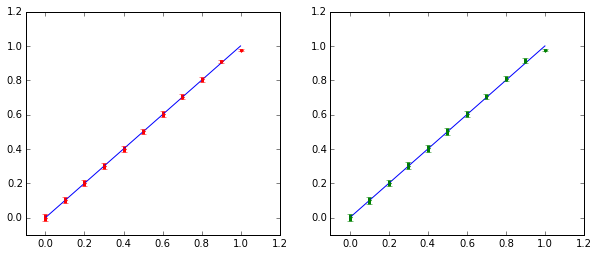

In [8]:
median_f = np.empty(VF.size)
lower_p = np.empty(VF.size)
upper_p = np.empty(VF.size)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# plot ground truth lines
axs[0].plot([0, 1], [0, 1], 'b')
axs[1].plot([0, 1], [0, 1], 'b')

for idx, fa_i in enumerate([4, 0]):
    for vf_i in range(VF.size):
        median_f[vf_i] = np.median(f[fa_i, vf_i, :])
        p25, p75 = np.percentile(f[fa_i, vf_i, :], [25 ,75])
        lower_p[vf_i] = median_f[vf_i] - p25 
        lower_p[vf_i] = p75 - median_f[vf_i]
    axs[idx].errorbar(VF/100, median_f, fmt='.',
                      yerr=[lower_p, lower_p],
                      color=colors[fa_i],
                      ecolor=colors[fa_i],
                      linewidth=3.0)
    axs[idx].set_ylim([-0.1, 1.2])
    axs[idx].set_xlim([-0.1, 1.2])